
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [43]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
df = sns.load_dataset('penguins')
df.head()
droprows = df.T.isnull().sum().sort_values(ascending=False).head(2).index

In [45]:
target = 'species'
features = df.columns.drop(target).tolist()
df.shape
train, test = train_test_split(df, train_size=0.80, test_size=0.20, random_state=8)
df.isnull().sum()
df[target].value_counts(normalize=True)
#majority class baseline = 44%

Adelie       0.441860
Gentoo       0.360465
Chinstrap    0.197674
Name: species, dtype: float64

In [46]:
def wrangle(X):
  X= X.copy()
  X.sex = X.sex.fillna(value='UNK')
  droprows = X.T.isnull().sum().sort_values(ascending=False).head(2).index   ## two rows that have all 5 nans 
  X.drop(index=droprows, inplace=True)
  return X

X_train = wrangle(train)[features]
y_train = wrangle(train)[target]

X_test = wrangle(test)[features]
y_test = wrangle(test)[target]

X_train.shape,y_train.shape,X_test.shape
                       

((273, 6), (273,), (67, 6))

In [47]:
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, recall_score

logreg = make_pipeline(
    ce.OneHotEncoder(),
    LogisticRegression()
)
logreg.fit(X_train,y_train);
y_pred= logreg.predict(X_test)
y_pred_proba=logreg.predict_proba(X_test); #need for ROC

print('test' ,accuracy_score(y_test,y_pred ))

X_test_enc = logreg.named_steps['onehotencoder'].transform(X_test)


test 0.9701492537313433


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


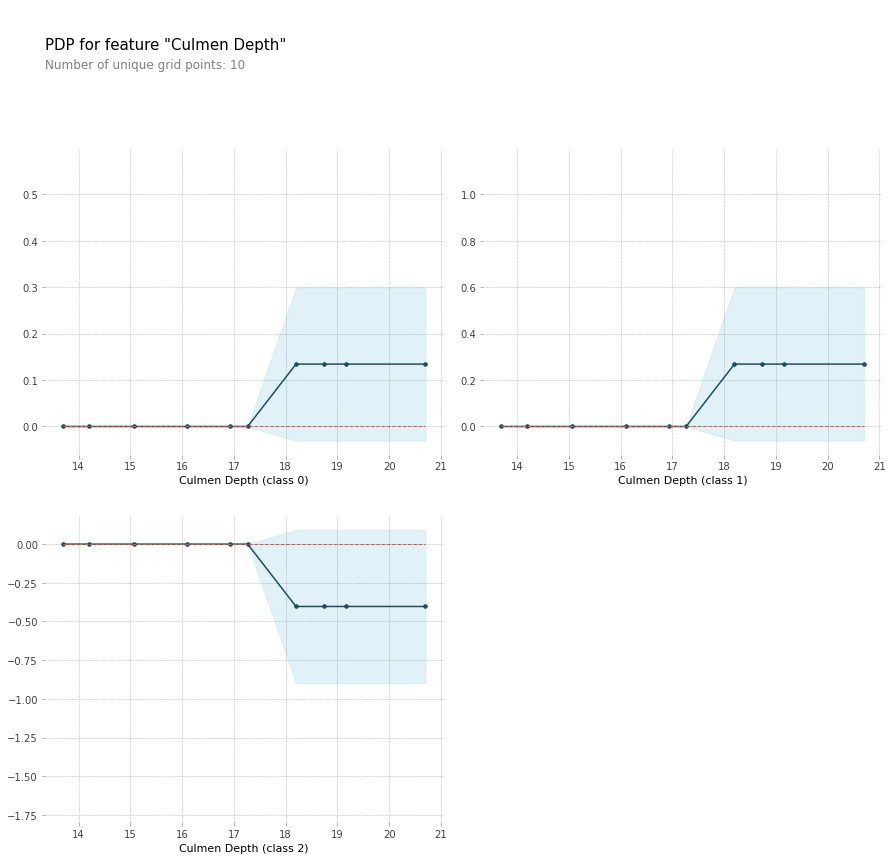

In [59]:
from sklearn.tree import DecisionTreeClassifier
dtc_model =  make_pipeline(
            ce.OrdinalEncoder(),
            DecisionTreeClassifier(max_depth=2)
)
dtc_model.fit(X_train,y_train)
y_pred= dtc_model.predict(X_test)

X_test_enc =dtc_model.named_steps['ordinalencoder'].transform(X_test)

feature_names= dtc_model.named_steps['ordinalencoder'].get_feature_names()
from pdpbox import pdp, get_dataset, info_plots
pdp_culmend=  pdp.pdp_isolate(model=dtc_model, dataset=X_test,
                              model_features=feature_names,feature ='culmen_depth_mm')
pdp.pdp_plot(pdp_culmend, 'Culmen Depth')
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


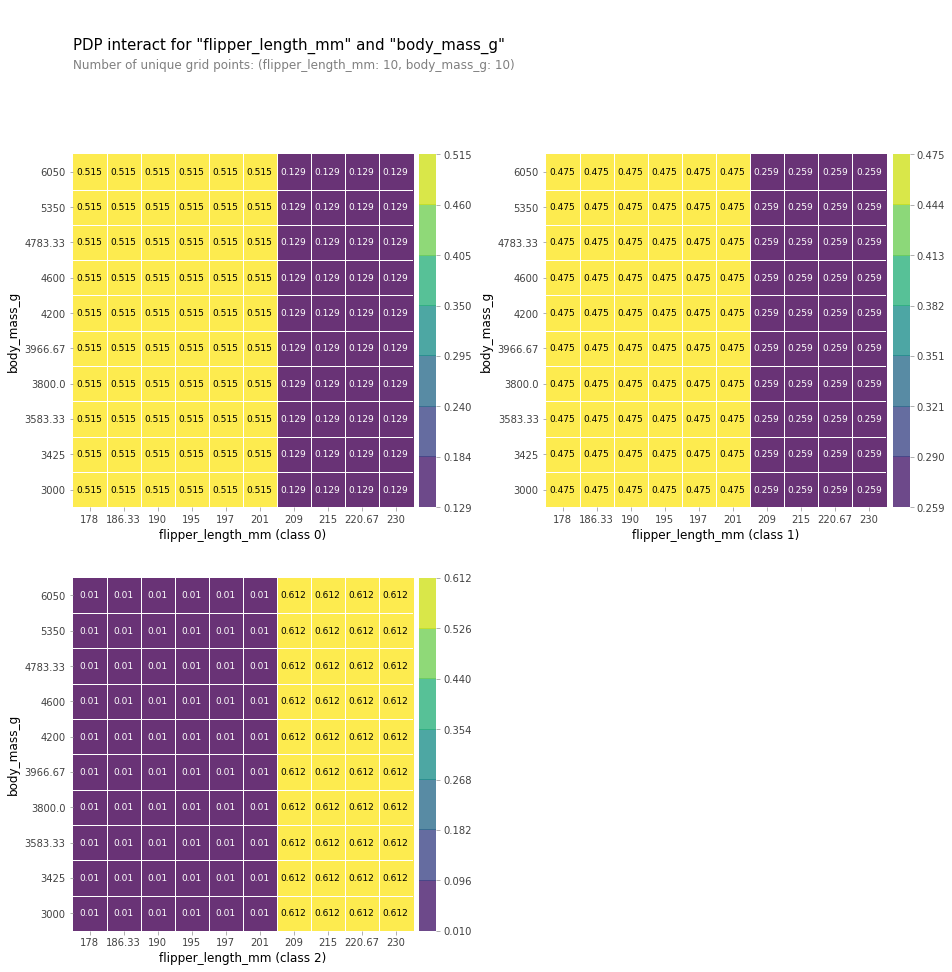

In [67]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['flipper_length_mm', 'body_mass_g']

interaction = pdp_interact(
    model=dtc_model, 
    dataset=X_test,
    model_features=X_test.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [74]:
X_test.iloc[[0]] 


,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,MALE


In [79]:


import shap
row = X_test_enc.iloc[[0]]   #explain this prediction 

model =dtc_model.named_steps['decisiontreeclassifier']

pred = dtc_model.predict(X_test)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0],
    features=row
)


In [87]:
pwd

'/home/dliu/lambda/unit-2/DS-Unit-2-Applied-Modeling/module4-model-interpretation'